In [1]:
import os
import nbimporter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
from DataParserforCNN import read_class
from StrokeRemoval import stroke_removal
import hull
import cv2
from DeformImage import *
from keras.utils import Sequence
from random import randint
from albumentations import *


%matplotlib inline

Importing Jupyter notebook from DataParserforCNN.ipynb


Using TensorFlow backend.


Importing Jupyter notebook from StrokeRemoval.ipynb
Importing Jupyter notebook from hull.ipynb
Importing Jupyter notebook from DeformImage.ipynb


In [2]:
class_array = read_class()
base_path = '/Volumes/JS/QuickDraw/train_simplified/'
airplane = pd.read_csv(base_path + 'airplane.csv', nrows=100)

In [3]:
def null_augment(drawing, label, index):
    image, _ = drawing_to_image(drawing, 64, 64)
    return image, label

def flip_augment(drawing, label, index):
    image, _ = drawing_to_image(drawing, 64, 64)
    image = np.fliplr(image)
    return image, label
    
def normalize(image):
    return image / 255.

def read_class():
    CLASS_NAME = []
    with open('./classes.txt', 'r') as class_file:
        for i, line in enumerate(class_file):
            line = line.rstrip('\n')
            CLASS_NAME.append(line)
    return CLASS_NAME

def globaldeformation(drawing, sigma=3):
    image, coords = drawing_to_image(drawing, 64, 64)
    hull_x, hull_y = np.array(hull.convex(coords)).T
    choose_four = [np.argsort(hull_x)[0], np.argsort(hull_x)[-1], 
                   np.argsort(hull_y)[0], np.argsort(hull_y)[-1]]
    p = []
    for i in choose_four:
        p.append([hull_x[i], hull_y[i]])
    p_x, p_y = np.array(p).T
    p = np.array(list(zip(p_x, p_y)))
    sigma=5
    noise_x = np.random.normal(0, sigma, 4)
    noise_y = np.random.normal(0, sigma, 4)
    x_with_noise = p_x + noise_x
    y_with_noise = p_y + noise_y
    x_with_noise = [int(min(max(0, x), 64)) for x in x_with_noise]
    y_with_noise = [int(min(max(0, y), 64)) for y in y_with_noise]
    q = np.array(list(zip(x_with_noise, y_with_noise)))
    new_img = mls_rigid_deformation_inv(image, p, q)
    new_img = np.array(new_img*255)
    new_img.astype('uint')
    return new_img

In [4]:
def random_augment(drawing, label, index):
    number = randint(1, 5)
    if number == 5:   # remove strokes
        drawing = stroke_removal(drawing, percent=0.35)
    image, _ = drawing_to_image(drawing, 64, 64)

    if number == 1:  # null augment
        image = image
    elif number == 2:      # random flip 
        image = Flip(p=1)(image=image)['image']
    elif number == 3:      # random rotate
        image = Rotate(p=1, border_mode=cv2.BORDER_CONSTANT)(image=image)['image']
    elif number == 4:   # hull augment
        image = globaldeformation(drawing)
    return image, label

In [83]:
def test_augment(drawing, label, index):
    image, _ = drawing_to_image(drawing, 64,64)
#     image = Cutout(num_holes=4, max_h_size=8, max_w_size=8, p=1)(image=image)['image']
#     image = MedianBlur(blur_limit=5, p=1)(image=image)['image']
#     image = Blur(p=1, blur_limit=4)(image=image)['image']
    image = Transpose(p=1.0)(image=image)['image']
#     image = GaussNoise(p=1.0)(image=image)['image']
#     image = InvertImg(p=1.0)(image=image)['image']
    return image, label

In [84]:
def drawing_to_image(drawing, H, W):

    point=[]
    time =[]
    
    for t,(x,y) in enumerate(drawing):
        point.append(np.array((x,y),np.float32).T)
        time.append(np.full(len(x),t))

    point = np.concatenate(point).astype(np.float32)
    time  = np.concatenate(time).astype(np.int32)
    
    coords = []
    
    image  = np.full((H,W,3),0,np.uint8)
    x_max = point[:,0].max()
    x_min = point[:,0].min()
    y_max = point[:,1].max()
    y_min = point[:,1].min()
    w = x_max-x_min
    h = y_max-y_min
    #print(w,h)

    s = max(w,h)
    norm_point = (point-[x_min,y_min])/s
    norm_point = (norm_point-[w/s*0.5,h/s*0.5])*max(W,H)*0.85
    norm_point = np.floor(norm_point + [W/2,H/2]).astype(np.int32)

    T = time.max()+1
    for t in range(T):
        p = norm_point[time==t]
        x,y = p.T
        image[y,x]=255
        N = len(p)
        for i in range(N-1):
            x0,y0 = p[i]
            x1,y1 = p[i+1]
            coords.append((x0, y0))
            cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA)
        coords.append((x1, y1))

    return image, coords

In [85]:
class ImageBatchGenerator(Sequence):
    def __init__(self, 
                 class_array,
                 full_df,
                 datasplit_id,
                 split='train_set',
                 batch_size=128, 
                 augment=null_augment, 
                 mode='simplified',
                 norm=None,
                 shuffle=True):
        """ data: could be 'train' or 'test', the former used to get splited dataset train_set or valid_set, 
                  the latter used to get the TEST_DF
        """
        assert mode in ['simplified', 'raw']
        
        self.class_array = class_array
        self.full_df = full_df
        self.datasplit_id = datasplit_id
        self.split = split
        self.norm = norm
        
        self.batch_size = batch_size
        self.augment = augment
        self.mode = mode 
        self.H, self.W = 64, 64

        num_class = len(class_array)
        

        ### shuffle                    
        if shuffle:
            np.random.shuffle(self.datasplit_id)
        print('\n')

        
    def __str__(self):
        N = len(self.datasplit_id)
        string = ''\
        + '\tdata         = %s\n'%self.split \
        + '\tmode         = %s\n'%self.mode \
        + '\tlen(self.datasplit_id) = %d\n'%N \
        + '\n'
        return string


    def __getitem__(self, idx):
        if self.split != 'test_set':
            l_bound = idx * self.batch_size
            r_bound = (idx + 1) * self.batch_size
            if r_bound > len(self.datasplit_id):
                r_bound = len(self.datasplit_id)
                l_bound = r_bound - self.batch_size
            instance_count = 0

            x_batch = np.zeros((r_bound-l_bound, self.H, self.W, 3))
            y_batch = np.zeros((r_bound-l_bound, 340), dtype='uint32')

            for instance in self.datasplit_id[l_bound:r_bound]:
                label, drawing_id, key_id = instance
                drawing = self.full_df[label]['drawing'][drawing_id]
                drawing = eval(drawing)

                image, label = self.augment(drawing, label, idx)

                x_batch[instance_count] = image
                y_batch[instance_count, int(label)] = 1

                if self.norm != None:
                    x_batch[instance_count] = self.norm(image)

                instance_count += 1
        else:
            pass

        return [x_batch, y_batch]

        if self.data == 'test':
            label=None
            drawing = self.df['drawing'][idx]
            drawing = eval(drawing)

        return self.augment(drawing, label, idx)


    def __len__(self):
        return int(np.ceil(len(self.datasplit_id) / self.batch_size))

In [86]:
train_id = []
df = []
df.append(airplane)
key_id = airplane['key_id']
label = np.full(len(key_id), 0, dtype=np.int64)
drawing_id = airplane.loc[airplane['key_id'].isin(key_id)].index.values
train_id.extend(np.vstack([label, drawing_id, key_id]).T)

In [87]:
train_batch = ImageBatchGenerator(class_array=class_array,
                                  full_df=df,
                                  datasplit_id=train_id,
                                  split='train_set',
                                  batch_size=4, 
                                  augment=test_augment, 
                                  mode='simplified', 
                                  norm=normalize,
                                  shuffle=False)

In [88]:
len(train_batch)

25

In [89]:
len(train_batch[0][0][3])

64

In [90]:
def draw_a_batch(train_batch, batch_size=4):
    fig, m_axs = plt.subplots(1, 4, figsize=(16, 16))

    for i, ax in enumerate(m_axs.flatten()):
        img = train_batch[0][0][i]
        ax.imshow(img.astype('float'))

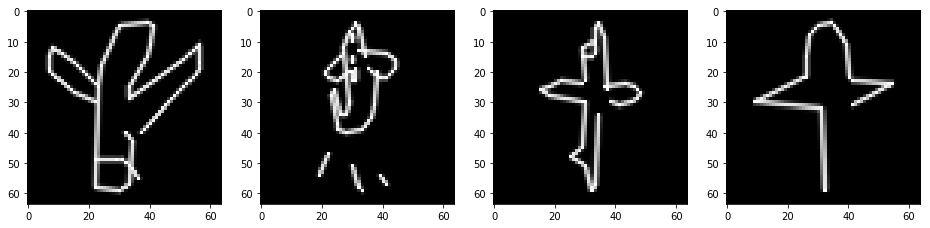

In [91]:
draw_a_batch(train_batch)

In [13]:
train_batch_2 = ImageBatchGenerator(class_array=class_array,
                                  full_df=df,
                                  datasplit_id=train_id,
                                  split='train_set',
                                  batch_size=4, 
                                  augment=random_augment, 
                                  mode='simplified', 
                                  norm=normalize,
                                  shuffle=False)

DeformImage.ipynb:516: RuntimeWarning: divide by zero encountered in true_divide
  "    vy, vx = np.meshgrid(gridX, gridY)\n",


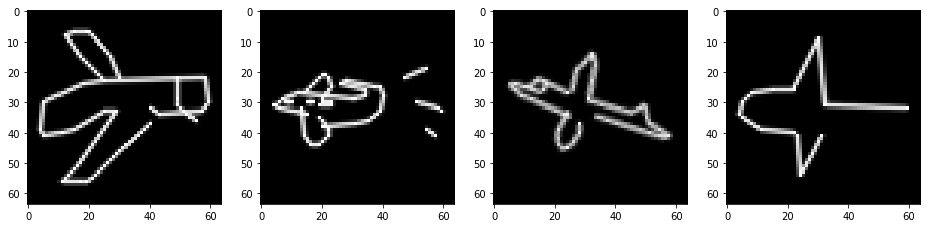

In [14]:
draw_a_batch(train_batch_2)